# RBM training $ L=9$  - Dataset with 25 different temperatures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn
torch.manual_seed(12)

import sys
# sys.path.append('../modules')
from rbm_L9 import RBM
from mc_ising2d import IsingMC
import os

In [2]:
L = 9

## Dataset with $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L9_Ising2D_MC.pkl` contains spins configurations for a square lattice $L\times L$, with $L=9$. There are 2000 spins configurations for each of 25 different temperatures $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

In [3]:
ising_data = pd.read_pickle(f'L{L}_Ising2D_MC.pkl')
ising_data.head()

,state,magn,energy,temp
0,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ...",5,-14,6.0
1,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...",9,-30,6.0
2,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",1,-2,6.0
3,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",-19,-38,6.0
4,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...",1,-22,6.0


In [4]:
ising_data['temp'].value_counts()

temp
6.000000    2000
2.750000    2000
0.250000    2000
0.500000    2000
0.750000    2000
1.000000    2000
1.250000    2000
1.500000    2000
1.750000    2000
2.000000    2000
2.250000    2000
2.500000    2000
3.000000    2000
5.750000    2000
3.250000    2000
3.500000    2000
3.750000    2000
4.000000    2000
4.250000    2000
4.500000    2000
4.750000    2000
5.000000    2000
5.250000    2000
5.500000    2000
0.000001    2000
Name: count, dtype: int64

In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


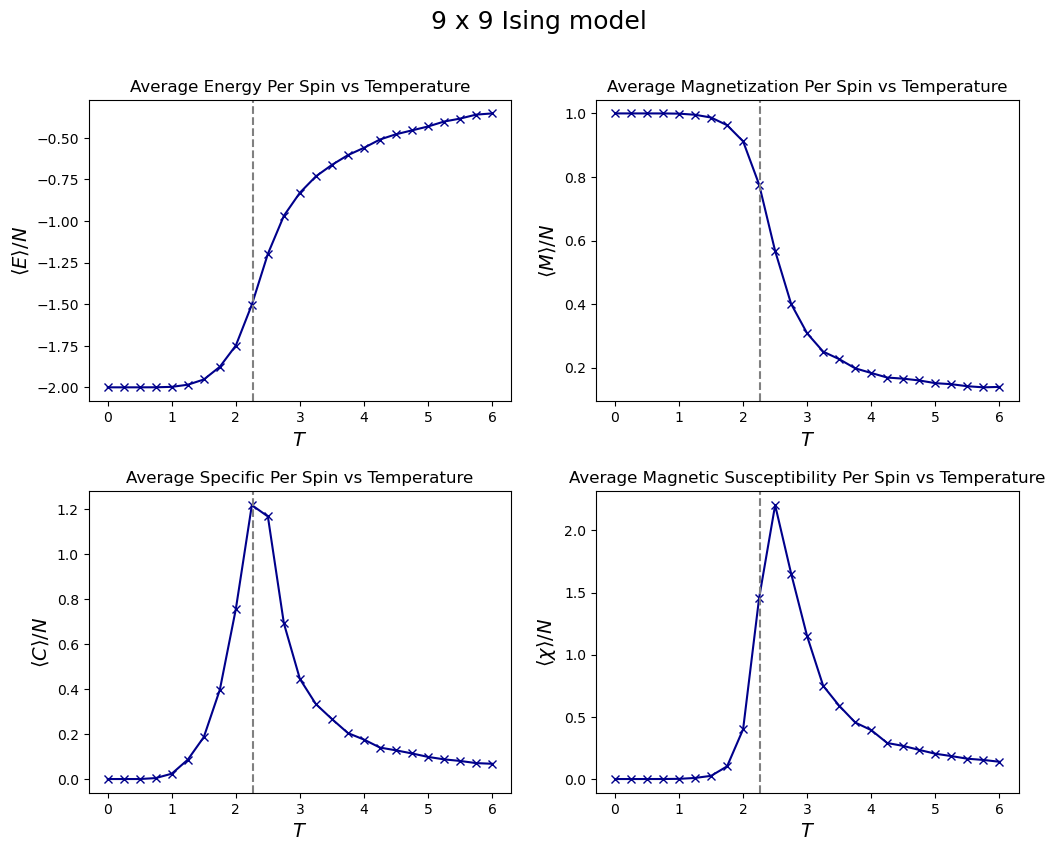

In [5]:
IsingMC(L= L).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

In [6]:
data = ising_data.drop(columns= ['energy', 'magn'])

### Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 25 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [7]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

### Training the model

Our code implementing a Restricted Boltzmann Machine is written a python class called `RBM` which is imported from `rbm.py`.

For simplification, the units have no bias and the RBM stochasticity parameter, represented below by $T$ is set to unity, as usual in most practical applications. Note that we set `use_cuda=True`, which makes use of [CUDA tensor types](https://pytorch.org/docs/stable/cuda.html), implementing GPU computation. If a GPU is not available, one should just set `use_cuda=False`.

In [8]:
train_numpy_array = np.stack([np.array(elem, dtype=np.float32) for elem in train_data_['state']])
test_numpy_array = np.stack([np.array(elem, dtype=np.float32) for elem in test_data_['state']])

# Convert the numpy arrays to PyTorch tensors
training_set = torch.tensor(train_numpy_array)
test_set = torch.tensor(test_numpy_array)

# Randomly shuffle the training data
training_set = training_set[torch.randperm(training_set.size(0))]

In [9]:
training_set.shape[1]

81

Training RBM 1/250
RBM --- Nv= 81, Nh= 81, lr= 1.0E-02, k= 1, Bsize= 100, Epochs= 1600, USE_CUDA= False, verbose= 10
Starting training
Ep 10, Rec er: 0.364693 (train), 0.363037 (test), Pseud_Lik: -31.933014, Time: 1.519378, 
Ep 20, Rec er: 0.342810 (train), 0.341660 (test), Pseud_Lik: -28.563427, Time: 1.482494, 
Ep 30, Rec er: 0.332202 (train), 0.333875 (test), Pseud_Lik: -26.927562, Time: 1.553698, 
Ep 40, Rec er: 0.326117 (train), 0.325283 (test), Pseud_Lik: -26.069664, Time: 1.514908, 
Ep 50, Rec er: 0.321447 (train), 0.321537 (test), Pseud_Lik: -25.378941, Time: 1.538832, 
Ep 60, Rec er: 0.317765 (train), 0.317848 (test), Pseud_Lik: -24.613822, Time: 1.553030, 
Ep 70, Rec er: 0.313926 (train), 0.314352 (test), Pseud_Lik: -23.999042, Time: 1.558269, 
Ep 80, Rec er: 0.310474 (train), 0.311925 (test), Pseud_Lik: -23.683359, Time: 1.552333, 
Ep 90, Rec er: 0.307063 (train), 0.307536 (test), Pseud_Lik: -23.232813, Time: 1.560009, 
Ep 100, Rec er: 0.304031 (train), 0.303785 (test), Pseu

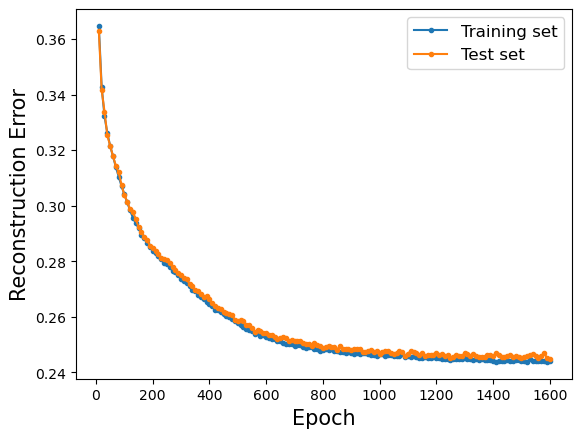

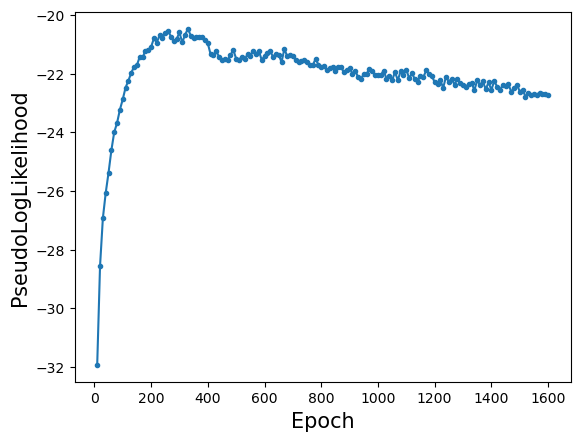

Training RBM 2/250
RBM --- Nv= 81, Nh= 81, lr= 1.0E-02, k= 1, Bsize= 100, Epochs= 1600, USE_CUDA= False, verbose= 10
Starting training
Ep 10, Rec er: 0.364111 (train), 0.362353 (test), Pseud_Lik: -31.855823, Time: 1.510964, 
Ep 20, Rec er: 0.341565 (train), 0.340514 (test), Pseud_Lik: -28.645088, Time: 1.526313, 
Ep 30, Rec er: 0.330661 (train), 0.330806 (test), Pseud_Lik: -27.211255, Time: 1.532665, 
Ep 40, Rec er: 0.323948 (train), 0.324279 (test), Pseud_Lik: -26.271131, Time: 1.584471, 
Ep 50, Rec er: 0.318572 (train), 0.319107 (test), Pseud_Lik: -25.331655, Time: 1.716152, 
Ep 60, Rec er: 0.314750 (train), 0.315801 (test), Pseud_Lik: -24.582883, Time: 1.564437, 
Ep 70, Rec er: 0.310756 (train), 0.311314 (test), Pseud_Lik: -23.842317, Time: 1.583326, 
Ep 80, Rec er: 0.307377 (train), 0.307854 (test), Pseud_Lik: -23.332564, Time: 1.585902, 
Ep 90, Rec er: 0.303871 (train), 0.304272 (test), Pseud_Lik: -22.797890, Time: 1.568091, 
Ep 100, Rec er: 0.300930 (train), 0.301360 (test), Pseu

KeyboardInterrupt: 

In [10]:

lr = 0.01
k_learning = 1
batch_size = 100
nb_epoch = 1600
k_sampling = 1

total_rbms = 250  # Total number of RBMs to train
rbms_per_batch = 5  # Number of RBMs per batch
temp_storage = []  # Temporary storage for each batch of RBMs

for rbm_index in range(total_rbms):
    print(f"Training RBM {rbm_index + 1}/{total_rbms}")

    # Initialize a new RBM
    rbm = RBM(num_visible=training_set.shape[1], 
              num_hidden=training_set.shape[1], 
              bias=False,
              T=1.0,
              use_cuda=False)

    # Train the RBM
    rbm.learn(training_set=training_set, 
              test_set=test_set,
              lr=lr, 
              nb_epoch=nb_epoch, 
              batch_size=batch_size,
              k_learning=k_learning,
              k_sampling=k_sampling,
              verbose=10)

    # Add the trained RBM to the temporary storage
    temp_storage.append(rbm)

    # Save 2 RBMs as a batch
    if (rbm_index + 1) % rbms_per_batch == 0 or (rbm_index + 1) == total_rbms:
        batch_index = (rbm_index + 1) // rbms_per_batch
        torch.save(temp_storage, f'x_rbms_group_{batch_index}.pt')
        temp_storage = []  # Clear the temporary storage for the next batch


In [ ]:
all_rbms = []  # List to store all RBMs

# Loop through each file and load the RBMs
for i in range(1, 101):  # Assuming file names are from 1 to 100
    file_name = f'rbms_group_{i}.pt'
    rbms_batch = torch.load(file_name)
    all_rbms.extend(rbms_batch)  # Add the loaded RBMs to the list

# Save all RBMs into one file
# torch.save(all_rbms, '200epochs__250_rbms.pt')

<Axes: >

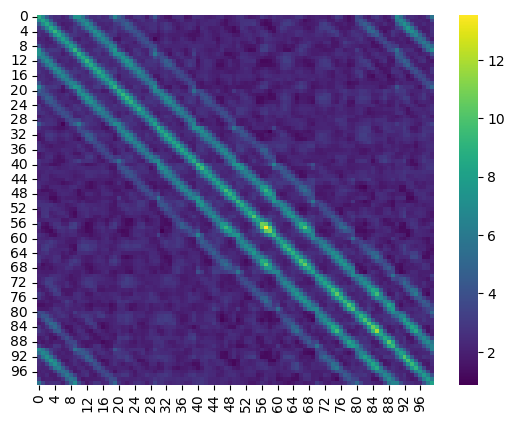

In [12]:
loaded_rbms = torch.load('rbms_group_1.pt')
w = loaded_rbms[0].parameters()[0]
w = torch.mm(w.t(),w)
sns.heatmap(w, linewidths= 0.0, cmap= 'viridis')

### Saving the multiple batches into 1

In [9]:
nb_epoch= rbm.num_train_epochs()
Nv= training_set.shape[1]
Nh= training_set.shape[1]

name = 'RBM_model_T_complete_nv%d_nh%d_lr%.1E_k%d_bsize%d_nepochs%d' % (Nv,
                                                                        Nh,
                                                                        lr,
                                                                        k_learning,
                                                                        batch_size,
                                                                        nb_epoch)

PATH = name + '.pt'

torch.save(rbm, PATH)

### Weights distribution

In [10]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

In [11]:
W_layers = rbm.W_layers()

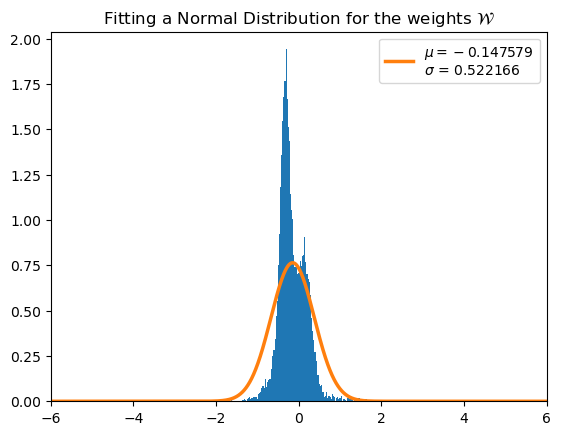

In [12]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_, sigmaW_ = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_, sigmaW_) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_, sigmaW_ ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-6, 6])
plt.legend()
plt.show()

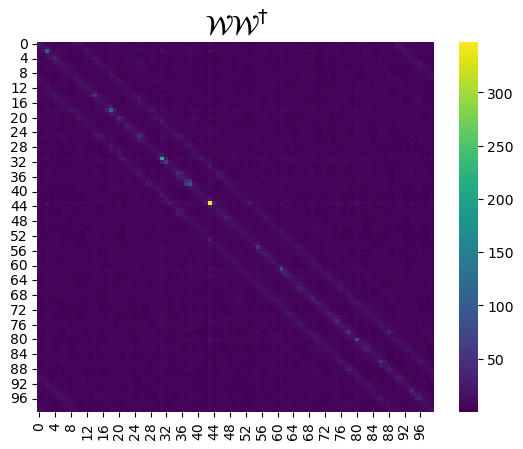

In [13]:
WW = torch.mm(W.t(), W)
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
plt.show()

### Comparing this weight distribution with the one from MF trainining set

In [14]:
rbm = torch.load('RBM_model_T_complete_nv100_nh100_lr1.0E-02_k1_bsize100_nepochs8000.pt')

In [15]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

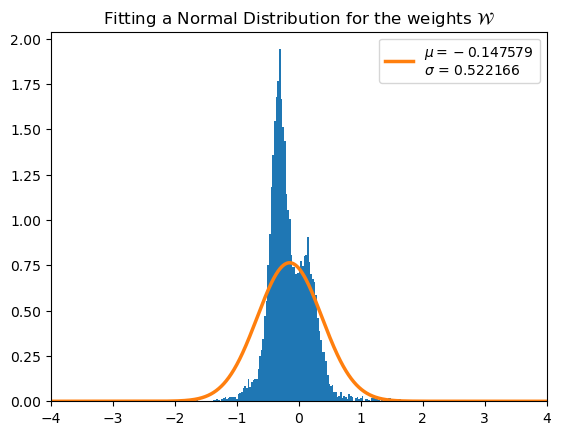

In [16]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_, sigmaW_ = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_, sigmaW_) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_, sigmaW_ ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-4, 4])
plt.legend()
plt.show()

In [17]:
rbm_MF = torch.load('RBM_model_T_complete_MF_nv100_nh100_lr1.0E-03_k1_bsize100_nepochs20000.pt')

W_MF, v_MF, h_MF = rbm_MF.parameters()

del v_MF
del h_MF
torch.cuda.empty_cache()


FileNotFoundError: [Errno 2] No such file or directory: 'RBM_model_T_complete_MF_nv100_nh100_lr1.0E-03_k1_bsize100_nepochs20000.pt'

In [19]:
W_ = W_MF.cpu().numpy().reshape((W_MF.shape[0]*W_MF.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 100, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_MF, sigmaW_MF = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_MF, sigmaW_MF) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_MF, sigmaW_MF ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W} - MF$')
plt.xlim([-4, 4])
plt.legend()
plt.show()

NameError: name 'W_MF' is not defined

In [91]:
def distr_comp(muW_,
               sigmaW_,
               muW_MF,
               sigmaW_MF,
               L= 10,
               x_min= -5,
               x_max= 5,
               x_num= 500,
               loc_legend= 'lower right',
               training_set= 'COMPLETE',
               save= False, 
               publication= False):
              
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        alpha= 0.1
        fontsize_t = 6.0
        linewidth_v= 0.5
        
    else:
        markersize = 10.0
        linewidth= 1.5
        alpha= 0.1
        fontsize_t = 12.0
        linewidth_v= 0.8
        
           
    x = np.linspace(x_min, x_max, x_num)
    plot_pdf = stats.norm.pdf(x, muW_, sigmaW_)
    plot_pdf_MF = stats.norm.pdf(x, muW_MF, sigmaW_MF)

    plt.plot(x, 
             plot_pdf, 
             linewidth= linewidth,
             label= 'Nearest Neig')

    plt.fill_between(x, 
                     plot_pdf,
                     alpha= alpha)

    plt.plot(x, 
             plot_pdf_MF,
             linewidth= linewidth,
             label= 'Mean Field')

    plt.fill_between(x,
                     plot_pdf_MF,
                     alpha= alpha)
    
    plt.axvline(x= 0.0, linestyle= ':', linewidth= linewidth_v, color= 'black')

    plt.ylim([0, plt.ylim()[1]])
    plt.legend(loc= loc_legend,
              fontsize= fontsize_t)
    
    if save:
        if publication:
            path_fig = '../figures/PUB_DISTRIB_COMP_NN_vs_MF_L%d_Train%s.pdf' % (L, training_set)   
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            path_fig = '../figures/DISTRIB_COMP_NN_vs_MF_L%d_Train%s.pdf' % (L, training_set)   
            plt.savefig(path_fig, bbox_inches='tight')
    
    plt.show()

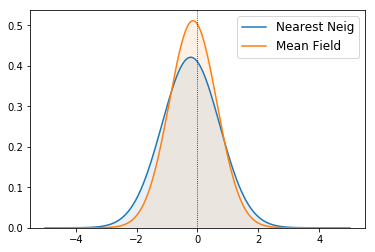

In [93]:
distr_comp(muW_= muW_,
           sigmaW_= sigmaW_,
           muW_MF= muW_MF,
           sigmaW_MF= sigmaW_MF,
           L= 10,
           x_min= -5,
           x_max= 5,
           x_num= 500,
           loc_legend= 'upper right',
           training_set= 'COMPLETE',
           save= False, 
           publication= False)